In [113]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn.numerics import odeint, Euler, HyperEuler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [85]:
class Lorenz(nn.Module):
    def __init__(self):
        super().__init__()
        self.p = nn.Linear(1,1)
    
    def forward(self, t, x):
        x1, x2, x3 = x[...,:1], x[...,1:2], x[...,2:]
        dx1 = 10 * (x2 - x1)
        dx2 = x1 * (28 - x3) - x2
        dx3 = x1 * x2 - 8/3 * x3
        return torch.cat([dx1, dx2, dx3], -1)

In [115]:
x0 = torch.randn(4, 3) + 15
t_span = torch.linspace(0, 10, 4000)
sys = Lorenz()
t_eval, sol_gt = odeint(sys, x0, t_span, solver='tsit5', atol=1e-8, rtol=1e-8)

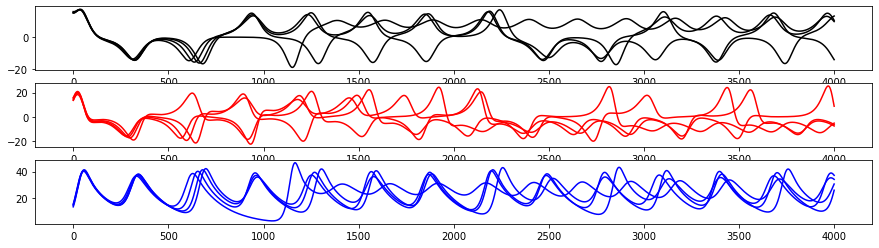

In [116]:
fig = plt.figure(figsize=(15, 4))
axs = fig.subplots(3,1)
axs[0].plot(sol_gt[:,:,0], c='black'); axs[1].plot(sol[:,:,1], c='r'); axs[2].plot(sol_gt[:,:,2], c='b');

#### Can we speed up simulation?

In [117]:
class VanillaHyperNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
    def forward(self, t, x):
        return self.net(x)

In [118]:
net = nn.Sequential(nn.Linear(3, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 3))
hypersolver = HyperEuler(VanillaHyperNet(net))
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver, atol=1e-5, rtol=1e-5)
sol = sol.detach()

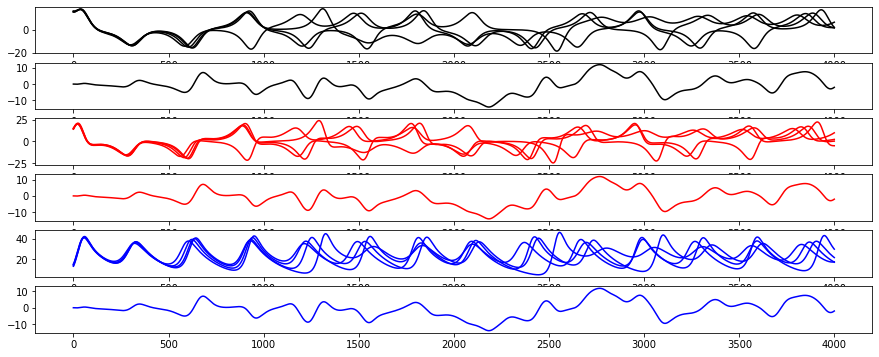

In [119]:
# The error accumulates as Euler is not enough. 
fig = plt.figure(figsize=(15, 6))
axs = fig.subplots(6,1)
axs[0].plot(sol[:,:,0], c='black'); axs[2].plot(sol[:,:,1], c='r'); axs[4].plot(sol[:,:,2], c='b');
# plotting the errors (mean across batches of initial conditions)
axs[1].plot((sol-sol_gt)[:,:,0].mean(1), c='black')
axs[3].plot((sol-sol_gt)[:,:,0].mean(1), c='r')
axs[5].plot((sol-sol_gt)[:,:,0].mean(1), c='b');

#### Train the Hypersolver

We can train our hypersolver on residuals between ground-truth solution and base solver (in this case Euler)

In [114]:
base_solver = Euler()


In [ ]:
base_solver.step()

In [34]:
#Let's fine-tune the hypernetwork
import torchdiffeq
import time

In [38]:
t_span = torch.linspace(0, 10, 5)

t0 = time.time()
t_eval, sol = odeint(sys, x0, t_span, solver='tsit5', atol=1e-5, rtol=1e-5)
t_end = time.time() - t0; print(t_end)

0.22856688499450684


In [39]:
t0 = time.time()
sol = torchdiffeq.odeint(sys, x0, t_span, method='dopri5', atol=1e-5, rtol=1e-5)
t_end = time.time() - t0; print(t_end)

0.28225064277648926


#### Solving with `MS` variants

In [111]:
class MSRoot(MultipleShootingProblem):
    """Neural Multiple Shooting (nMS) layer solved via quasi-newton"""
    def __init__(self, vf, t_span, maxiter,
                 coarse_method='euler', fine_method='rk4', backward_sensitivity='adjoint', *args, **kwargs):
        super().__init__(vf=vf, t_span=t_span, coarse_method=coarse_method, fine_method=fine_method,
                         maxiter=maxiter, backward_sensitivity=backward_sensitivity,
                         func_forward='newton', *args, **kwargs)

    def _forward_autograd(self, z, B):
        i = 0
        B = B.requires_grad_(True)
        while i <= self.maxiter:
            i += 1
            B_fine = odeint(self.vf, B, self.sub_t_span, method=self.fine_method,
                            rtol=self.fine_rtol, atol=self.fine_atol)[-1]

            B_out = torch.zeros_like(B)
            B_out[:i] = B[:i]
            B_in = B[i-1]
            for m in range(i, self._n_sub):
                # instead of jvps here the full jacobian can be computed and the vector products
                # which involve `B_in` can be performed. Trading memory ++ for speed ++
                J_blk = torch.autograd.grad(B_fine[m-1], B, B_in - B[m-1], retain_graph=True)[0][m-1]
                B_in = B_fine[m-1] + J_blk
                B_out[m] = B_in
            del B # manually free graph
            B = B_out
        return B

In [112]:
class MSDirect(MultipleShootingProblem):
    """Neural Multiple Shooting (nMS) layer solved via forward sensitivity analysis
    on the matching conditions of shooting parameters"""

    def __init__(self, vf, t_span, maxiter,
                 coarse_method='euler', fine_method='rk4', backward_sensitivity='adjoint', *args, **kwargs):
        super().__init__(vf=vf, t_span=t_span, coarse_method=coarse_method, fine_method=fine_method,
                         maxiter=maxiter, backward_sensitivity=backward_sensitivity,
                         func_forward='direct', *args, **kwargs)

    def _forward_autograd(self, z, B):
        i = 0
        while i <= self.maxiter:
            i += 1
            B_fine, V_fine = self.forward_sensitivity(B[i-1:], self.sub_t_span,
                                                      method=self.fine_method,
                                                      rtol=self.fine_rtol,
                                                      atol=self.fine_atol)
            B_fine, V_fine = B_fine[-1], V_fine[-1]

            B_out = torch.zeros_like(B)
            B_out[:i] = B[:i]
            B_in = B[i-1]
            for m in range(i, self._n_sub):
                B_in = B_fine[m-i] + torch.einsum('bij, bj -> bi', V_fine[m-i], B_in - B[m-1])
                B_out[m] = B_in
            B = B_out
        return B

In [136]:
ms = MSDirect(Lorenz(), t_span, maxiter=10, fine_steps=20, fine_method='rk4', backward_sensitivity='autograd')
direct_sol = ms(z0).detach().cpu()

In [137]:
ms = MSZero(Lorenz(), t_span, maxiter=10, fine_method='rk4', backward_sensitivity='autograd')
zero_sol = ms(z0).detach().cpu()

In [115]:
# ms = MSDescent(Lorenz(), t_span, lr=10, maxiter=500, fine_steps=4, fine_method='rk4', backward_sensitivity='autograd')
# gd_sol = ms(z0).detach().cpu()

In [116]:
# ms = MSRoot(Lorenz(), t_span, maxiter=5, fine_steps=5, fine_method='rk4', backward_sensitivity='autograd')
# root_sol = ms(z0).detach().cpu()

In [128]:
def smape(yhat, y):
    return torch.abs(yhat - y) / (torch.abs(yhat) + torch.abs(y)) / 2

tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00]],

        [[1.6466e-08, 0.0000e+00, 0.0000e+00],
         [3.2260e-08, 0.0000e+00, 1.6721e-08],
         [0.0000e+00, 0.0000e+00, 0.0000e+00],
         ...,
         [2.9800e-08, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 1.7459e-08, 0.0000e+00],
         [2.6167e-08, 1.7496e-08, 0.0000e+00]],

        [[4.9383e-08, 3.1713e-08, 0.0000e+00],
         [4.8357e-08, 0.0000e+00, 1.6495e-08],
         [1.6300e-08, 6.2430e-08, 5.0491e-08],
         ...,
         [1.4918e-08, 1.6884e-08, 3.0757e-08],
         [3.0298e-08, 3.4462e-08, 1.5125e-08],
         [5.2462e-08, 0.0000e+00, 5.6914e-08]],

        ...,

        [[4.0741e-05, 1.6746e-05, 1.2074e-05],
         [2.0331e-04, 4.4120e-05, 4.9220e-05]

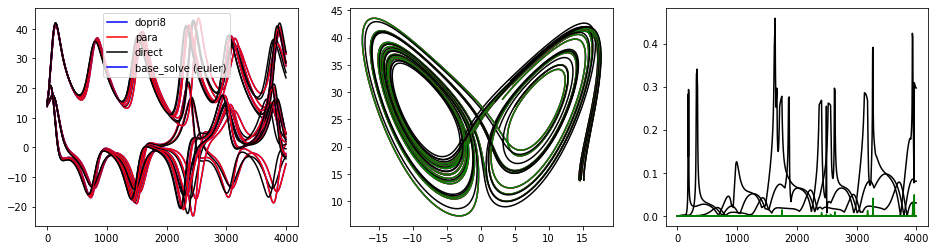

In [139]:
err_zero = smape(zero_sol, accurate_sol)[:,:2].mean(1)
err_base = smape(base_sol, accurate_sol)[:,:2].mean(1)
err_direct = smape(direct_sol, accurate_sol)[:,:2].mean(1)
#err_gd = torch.norm(gd_sol - accurate_sol, p=2, dim=-1)[:,0]

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
for i in range(4):
    for j in range(3):
        ax.plot(accurate_sol[:,i,j], c='b')
        ax.plot(zero_sol[:,i,j], c='r')
#        ax.plot(direct_sol[:,i,j], c='green')        
#        ax.plot(root_sol[:,i,j], c='orange')
        ax.plot(base_sol[:,i,j], c='black')
        ax.legend(['dopri8', 'para', 'direct', 'base_solve (euler)'])
        
ax = fig.add_subplot(1,3,2)
for i in range(4):
    ax.plot(accurate_sol[:,i,0], accurate_sol[:,i,2], c='blue')
    ax.plot(zero_sol[:,i,0], zero_sol[:,i,2], c='r')
    ax.plot(direct_sol[:,i,0], direct_sol[:,i,2], c='green')
#    ax.plot(gd_sol[:,i,0], gd_sol[:,i,2], c='orange')
    ax.plot(base_sol[:,i,0], base_sol[:,i,2], c='black')


ax = fig.add_subplot(1,3,3)
ax.plot(err_zero, c='r')
ax.plot(err_base, c='black')
ax.plot(err_direct, c='green')
#ax.plot(err_gd, c='orange')

plt.

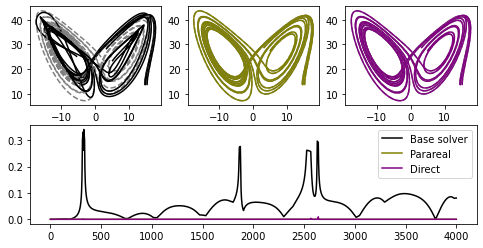

In [171]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(2,3,1)
for i in range(4):
    ax.plot(accurate_sol[:,i,0], accurate_sol[:,i,2], c='grey', linestyle='--')
    ax.plot(zero_sol[:,i,0], base_sol[:,i,2], c='black')
    
ax = fig.add_subplot(2,3,2)
for i in range(4):
    ax.plot(accurate_sol[:,i,0], accurate_sol[:,i,2], c='grey', linestyle='--')
    ax.plot(zero_sol[:,i,0], zero_sol[:,i,2], c='olive')
    
ax = fig.add_subplot(2,3,3)
for i in range(4):
    ax.plot(accurate_sol[:,i,0], accurate_sol[:,i,2], c='grey', linestyle='--')
    ax.plot(zero_sol[:,i,0], direct_sol[:,i,2], c='purple')
    
ax = fig.add_subplot(2,1,2)
ax.plot(err_base[:,0], c='black')
ax.plot(err_zero[:,0], c='olive')
ax.plot(err_direct[:,0], c='purple')
ax.legend(['Base solver', 'Parareal', 'Direct'])